# Prévisions météo en Australie

# Prétraitement des données

## Récupération des librairies

In [2]:
# récupération du package scikit-plot
!pip install scikit-plot

In [4]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency
from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Récupération et amélioration du jeu de données

### Préparation des données

In [3]:
# récupération et aperçu du jeu de données d'origine
df = pd.read_csv('data/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
# taille du DataFrame initial
obs_init = df.shape[0]
var_init = df.shape[1]

print("Taille du DataFrame initial:\n")
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Taille du DataFrame initial:

Nombre d'observations : 145460 
 Nombre de variables : 23


In [5]:
# suppression des doublons
df.drop_duplicates(inplace=True)

In [6]:
# détection des valeurs manquantes sur tout le DataFrame
print("Pourcentage de valeurs manquantes sur tout le DataFrame: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0] * 100)

Pourcentage de valeurs manquantes sur tout le dataframe: 



Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64

 - Les variables "Sunshine", "Evaporation", "Cloud3pm" et "Cloud9am" présentent la plus forte proportion de valeurs manquantes (entre 35% et 50%).
 - Les variables "Date" et "Location" n'ont pas de valeurs manquantes.
 - Les autres variables présentent moins de 10% de valeurs manquantes.

In [7]:
# suppression des valeurs manquantes pour "RainToday" et "RainTomorrow" qui ne contiennent que deux modalités.
df.dropna(subset=['RainTomorrow', 'RainToday'], inplace=True)

In [8]:
# encodage des variables qualitatives binaires
df['RainToday'].replace({'No':0, 'Yes':1}, inplace = True)
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace = True)

df['RainToday'] = df['RainToday'].astype('int64')
df['RainTomorrow'] = df['RainTomorrow'].astype('int64')

In [9]:
# remplacement des NANs avec l'algorithme KNN-Imputer pour les variables présentant la plus forte proportion de valeurs manquantes
# temps de calcul : ~ 1 h 20 min
X = df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']]
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = make_pipeline(KNNImputer(), SGDClassifier())

params = {'knnimputer__n_neighbors' : [4,5,6]}

grid = GridSearchCV(model, param_grid=params, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'knnimputer__n_neighbors': [4, 5, 6]})

In [12]:
grid.best_params_

{'knnimputer__n_neighbors': 5}

In [13]:
# remplacement des NANs avec l'algorithme KNN-Imputer pour les variables présentant la plus forte proportion de valeurs manquantes
# temps de calcul : ~ 20 min.
imputer = KNNImputer(n_neighbors = grid.best_params_['knnimputer__n_neighbors'])
df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']] = imputer.fit_transform(df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']])

In [14]:
# détection des valeurs manquantes sur tout le DataFrame
print("Pourcentage de valeurs manquantes sur tout le DataFrame: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0]*100)

Pourcentage de valeurs manquantes sur tout le DataFrame: 



Pressure3pm      9.780022
Pressure9am      9.761555
WindDir9am       6.861429
WindGustDir      6.508413
WindGustSpeed    6.467216
WindDir3pm       2.606775
Humidity3pm      2.486735
Temp3pm          1.863808
WindSpeed3pm     1.797751
Humidity9am      1.077514
WindSpeed9am     0.749359
Temp9am          0.465952
MinTemp          0.332417
MaxTemp          0.218060
RainToday        0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Date             0.000000
Location         0.000000
Sunshine         0.000000
Evaporation      0.000000
Rainfall         0.000000
RainTomorrow     0.000000
dtype: float64

In [15]:
# isolement des variables quantitatives présentant moins de 10% de valeurs manquantes
num_vars_with_nans = ['Pressure3pm','Pressure9am','WindGustSpeed','Humidity3pm','Temp3pm','WindSpeed3pm','Humidity9am','WindSpeed9am','Temp9am','MinTemp','MaxTemp']

index_date = pd.to_datetime(df['Date'])
df = df.set_index(index_date)

df_date = df.set_index(index_date)[num_vars_with_nans]
df_date.head()

,Pressure3pm,Pressure9am,WindGustSpeed,Humidity3pm,Temp3pm,WindSpeed3pm,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp
Date,,,,,,,,,,,
2008-12-01,1007.1,1007.7,44.0,22.0,21.8,24.0,71.0,20.0,16.9,13.4,22.9
2008-12-02,1007.8,1010.6,44.0,25.0,24.3,22.0,44.0,4.0,17.2,7.4,25.1
2008-12-03,1008.7,1007.6,46.0,30.0,23.2,26.0,38.0,19.0,21.0,12.9,25.7
2008-12-04,1012.8,1017.6,24.0,16.0,26.5,9.0,45.0,11.0,18.1,9.2,28.0
2008-12-05,1006.0,1010.8,41.0,33.0,29.7,20.0,82.0,7.0,17.8,17.5,32.3


In [16]:
# remplacement des NANs pour les variables quantitatives présentant moins de 10% de valeurs manquantes avec la méthode interpolate
df_date = df_date.interpolate(method="time")

In [17]:
# réintégration des variables isolées dans le DataFrame d'origine
df[num_vars_with_nans] = df_date[num_vars_with_nans]

In [20]:
# détection des valeurs manquantes sur tout le DataFrame
print("Pourcentage de valeurs manquantes sur tout le DataFrame: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0]*100)

Pourcentage de valeurs manquantes sur tout le DataFrame: 



WindDir9am       6.861429
WindGustDir      6.508413
WindDir3pm       2.606775
Date             0.000000
Humidity9am      0.000000
RainToday        0.000000
Temp3pm          0.000000
Temp9am          0.000000
Cloud3pm         0.000000
Cloud9am         0.000000
Pressure3pm      0.000000
Pressure9am      0.000000
Humidity3pm      0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Location         0.000000
WindGustSpeed    0.000000
Sunshine         0.000000
Evaporation      0.000000
Rainfall         0.000000
MaxTemp          0.000000
MinTemp          0.000000
RainTomorrow     0.000000
dtype: float64

In [21]:
# remplacement des valeurs manquantes pour les variables qualitatives en utilisant le mode
for feat in ['WindGustDir', 'WindDir9am', 'WindDir3pm'] :
    df[feat].fillna(df[feat].mode()[0], inplace=True)

In [22]:
# vérification finale sur le nombre de valeurs manquantes du DataFrame
df.isna().sum().sum()

0

In [23]:
# définition de nouvelles variables
df['Temp_Delta_MinMax'] = df['MaxTemp'] - df['MinTemp']
df['Humidity_Delta'] = df['Humidity3pm'] - df['Humidity9am']

In [24]:
# corrélations avec la variable cible
df.corr()['RainTomorrow'].sort_values(ascending=False)

RainTomorrow         1.000000
Humidity3pm          0.438034
RainToday            0.313097
Cloud3pm             0.305400
Cloud9am             0.260083
Humidity9am          0.256141
Humidity_Delta       0.253574
Rainfall             0.239032
WindGustSpeed        0.217533
WindSpeed9am         0.089186
WindSpeed3pm         0.085503
MinTemp              0.083992
Temp9am             -0.025635
Evaporation         -0.101904
MaxTemp             -0.159395
Temp3pm             -0.188807
Pressure3pm         -0.211297
Pressure9am         -0.229678
Temp_Delta_MinMax   -0.336272
Sunshine            -0.354916
Name: RainTomorrow, dtype: float64

In [25]:
# suppression des variables les moins corrélées à la variable cible (choix arbitraire : 'inférieur à 0.15 en valeur absolue')
df.drop(columns=['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'Temp9am', 'Evaporation'], inplace=True)

In [26]:
# suppression de la date car ni l'année, le mois, la semaine ou la journée ne sont pas très corrélées avec la variable cible (cf. "common_pyAusRainfall_dataviz.ipynb")
df.drop(columns=['Date'], inplace=True)

In [27]:
# définition de la fonction mesurant le niveau de corrélation par le V de Cramer
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0, (stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1, r_corr - 1))

In [28]:
# table de contingence entre entre les variables 'Humidity9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.27673959015296234


In [29]:
# table de contingence entre les variables 'Humidity_Delta' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity_Delta'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.28019656157074646


In [30]:
# suppression de la variable "Humidity9am", moins corrélée à la variable cible que "Humidity_Delta"
df.drop(columns=['Humidity9am'], inplace=True)

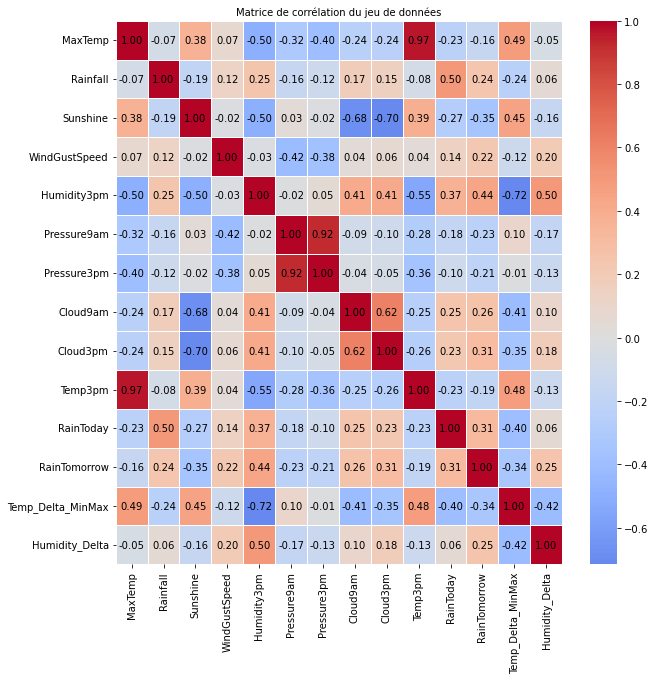

In [31]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- "Temp3pm" et "MaxTemp" sont très fortement corrélées (+0.97)
- "Pressure9am" et "Pressure3pm" sont très fortement corrélées (+0.92)
- "Humidity3pm" et "Temp_Delta_MinMax" sont très fortement corrélées (-0.72)
- "Sunshine" et "Cloud3pm" sont fortement corrélées (-0.70)
- "Sunshine" et "Cloud9am" sont fortement corrélées (-0.68)
- "Cloud9am" et "Cloud3pm" sont fortement corrélées (+0.62)
- "Humidity3pm" et "Temp3pm" sont fortement corrélées (-0.55)

In [32]:
# table de contingence entre les variables "Pressure9am" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Pressure9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.24423121889156266


In [33]:
# table de contingence entre les variables "Pressure3pm" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Pressure3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.22808735874790356


In [34]:
# suppression de la variable "Pressure3pm", moins corrélée à la variable cible que "Pressure9am"
df.drop(columns=['Pressure3pm'], inplace=True)

In [35]:
# table de contingence entre les variables "Cloud9am" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Cloud9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.26769405554360165


In [36]:
# table de contingence entre les variables "Cloud3pm" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Cloud3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.3281607321744599


In [37]:
# suppression de la variable "Cloud9am", moins corrélée à la variable cible que "Cloud3pm"
df.drop(columns=['Cloud9am'], inplace=True)

In [38]:
# table de contingence entre les variables "Temp3pm" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Temp3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.20513636904544252


In [39]:
# table de contingence entre les variables "MaxTemp" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['MaxTemp'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.16957868606472762


In [40]:
# suppression de la variable "MaxTemp", moins corrélée à la variable cible que "Temp3pm"
df.drop(columns=['MaxTemp'], inplace=True)

In [41]:
# récupération des variables quantitatives
num_features = [col for col in df.columns if df[col].dtype != 'O']
num_data = df.select_dtypes(include='number')

print("Variables quantitatives: {}".format(num_features),'\n')
print("Nombre de variables quantitatives: {}".format(len(num_features)))

Variables quantitatives: ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta'] 

Nombre de variables quantitatives: 11


In [42]:
# cardinalité
for feature in num_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Rainfall': 679
Cardinalité de 'Sunshine': 1012
Cardinalité de 'WindGustSpeed': 68
Cardinalité de 'Humidity3pm': 101
Cardinalité de 'Pressure9am': 545
Cardinalité de 'Cloud3pm': 43
Cardinalité de 'Temp3pm': 500
Cardinalité de 'RainToday': 2
Cardinalité de 'RainTomorrow': 2
Cardinalité de 'Temp_Delta_MinMax': 1094
Cardinalité de 'Humidity_Delta': 165


In [43]:
# suppression de la variable "RainToday" qui ne contient que deux modalités et se comporte donc plutôt comme une variable qualitative 
# df.drop(columns=['RainToday'], inplace=True)

In [44]:
# mise à jour de la liste des colonnes du DataFrame
# num_features = [col for col in df.columns if df[col].dtype != 'O']

In [45]:
# récupération des variables qualitatives
cat_features = [col for col in df.columns if df[col].dtype == 'O']
cat_data = df.select_dtypes(include = 'O')

print("Variables qualitatives: ", cat_features,'\n')
print("Nombre de variables qualitatives: ", len(cat_features))

Variables qualitatives:  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] 

Nombre de variables qualitatives:  4


In [46]:
# cardinalité
for feature in cat_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Location': 49
Cardinalité de 'WindGustDir': 16
Cardinalité de 'WindDir9am': 16
Cardinalité de 'WindDir3pm': 16


In [47]:
# suppression des variables quantitatives "WindGustDir", "WindDir9am" et "WindDir3pm" qui présentent une cardinalité trop forte
df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

In [48]:
# mise à jour de la liste des colonnes du DataFrame
cat_features = [col for col in df.columns if df[col].dtype == 'O']

In [49]:
# transformation des variables qualitatives en variables numériques (Olivier)
# for column in cat_features:
#    l = df[column].value_counts().index.tolist() 
#    mapping = {x:y for x,y in zip(l, range(len(l)))}
#    df[column] = df[column].map(mapping) 

In [50]:
# dichotomisation (one hot encoding)
# onehot_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# def one_hot_encode(df, cat, prefix):
#     for col, pref in zip(cat, prefix):
#         dummy = pd.get_dummies(df[col], prefix=pref)
#         df = pd.concat([df, dummy], axis=1)
#         df = df.drop(col, axis=1)
#     return df

# df = one_hot_encode(df, onehot_features, ['wgd', 'wd9', 'wd3'])

In [51]:
# calcul des valeurs délimitant les outliers et remplacement des outliers par la valeur des limites 
for feature in ['WindGustSpeed','Humidity3pm','Pressure9am','Rainfall','Temp3pm','Temp_Delta_MinMax','Humidity_Delta']:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

In [52]:
# remplacement des valeurs manquantes en utilisant la moyenne
# for feat in num_features :
#     df[feat].fillna(df[feat].mean(), inplace=True)

In [53]:
# Vérification des valeurs manquantes sur tout le DataFrame
# df.isnull().sum().sum()

In [54]:
# taille du DataFrame réduit
print("Taille du DataFrame réduit:\n")

print("Nombre d'observations initial: {} \n Nombre de variables initial: {} \n".format(obs_init, var_init))
print("Nombre d'observations actuel: {} \n Nombre de variables actuel: {} \n".format(df.shape[0], df.shape[1]))

print("{} % des observations retirées".format(round(100*(obs_init-df.shape[0])/obs_init,1)))
print("{} % des variables retirées".format(round(100*(var_init-df.shape[1])/var_init,1)))

Taille du DataFrame réduit:

Nombre d'observations initial: 145460 
 Nombre de variables initial: 23 

Nombre d'observations actuel: 140787 
 Nombre de variables actuel: 12 

3.2 % des observations retirées
47.8 % des variables retirées


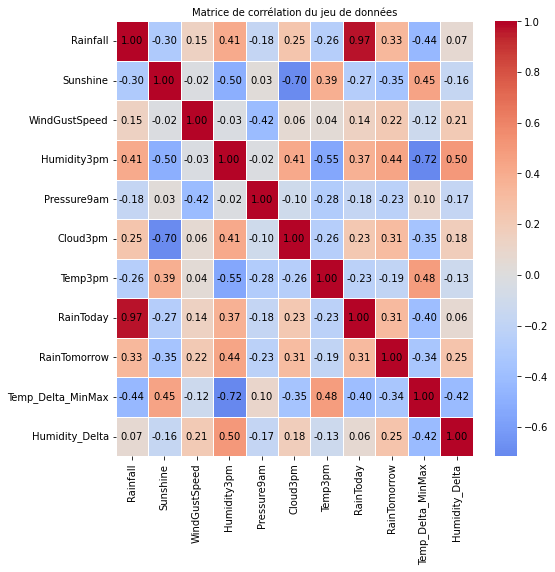

In [56]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(8,8))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- "RainToday" et "Rainfall" sont très fortement corrélées (+0.97)
- "Humidity3pm" et "Temp_Delta_MinMax" sont très fortement corrélées (-0.72)
- "Sunshine" et "Cloud3pm" sont fortement corrélées (-0.70)
- "Humidity3pm" et "Temp3pm" sont fortement corrélées (-0.55)

In [57]:
# table de contingence entre les variables "RainToday" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['RainToday'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.31306598504012456


In [58]:
# table de contingence entre les variables "Rainfall" et "RainTomorrow"
print("Table de contingence :")
table = pd.crosstab(df['Rainfall'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.3372604854774853


In [59]:
# suppression de la variable "RainToday", moins corrélée à la variable cible que "Rainfall"
df.drop(columns=['RainToday'], inplace=True)

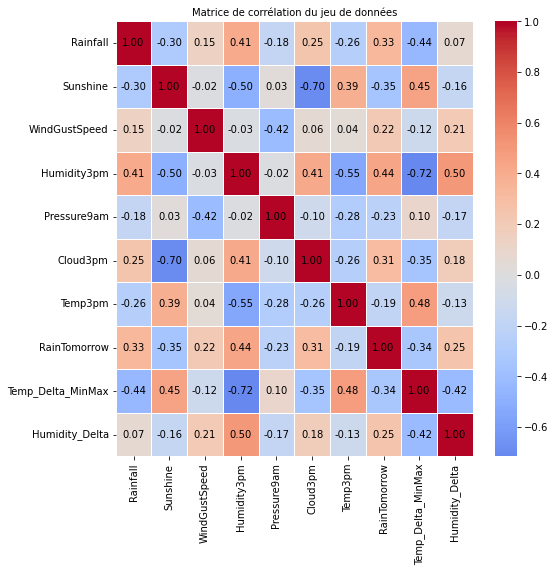

In [60]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(8,8))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

In [62]:
# sauvegarde du jeu de données après prétraitement et avant l'étape de classification des villes en fonction du climat
df.to_csv('data/weatherAUS_preprocessed_before_city_clust.csv')

## Classification des villes en fonction du climat

In [17]:
# récupération et aperçu du jeu de données après prétraitement et avant l'étape de classification des villes en fonction du climat
df = pd.read_csv("data/weatherAUS_preprocessed_before_city_clust.csv")
df.head()

,Date,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
0,2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0
1,2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0
2,2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0
3,2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0
4,2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0


In [18]:
# suppression de la variable "Date"
df.drop(columns=['Date'], inplace=True)

In [19]:
# récupération et aperçu des coordonnées géographiques
# aus_town_gps = pd.read_csv("old/aus_town_gps.csv", sep=",")
# aus_town_gps.head()

In [20]:
# récupération et aperçu du climat australien
aus_climats = pd.read_csv("data/climatsAUS_v2.csv", sep=";")
aus_climats.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [21]:
# regroupement des climats en 4 catégories: chaud_humide, tempéré_froid, sec et méditerranéen. 
climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

aus_climats['Clim_type'] = aus_climats['Climat_Koppen'].map(climats_type)

In [22]:
# aperçu du DataFrame "aus_climats"
aus_climats.head()

,Location,Climat_Koppen,Clim_type
0,Uluru,BSh,sec
1,Woomera,Bwh,sec
2,Adelaide,Csa,méditerranéen
3,Albany,Csb,méditerranéen
4,MountGambier,Csb,méditerranéen


In [23]:
# intégration des coordonnées géographiques et du climat australien dans le DataFrame étudié
# df = pd.merge(df, aus_town_gps, how='left', left_on="Location", right_on="Location")
df = pd.merge(df, aus_climats, how='left', left_on="Location", right_on="Location")

In [24]:
# encodage des variables liées au climat
clim_indic = pd.get_dummies(df.Clim_type, prefix='clim')
df = df.join(clim_indic).drop('Clim_type', axis=1)

In [25]:
# suppression des colonnes inutiles
df.drop(columns=['Location', 'Climat_Koppen'], inplace=True)

In [26]:
# aperçu du DataFrame "df"
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,1,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,1,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,1,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,1,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,1,0,0,0


In [27]:
# détection des valeurs manquantes sur tout le DataFrame
print("Pourcentage de valeurs manquantes sur tout le DataFrame: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0]*100)

Pourcentage de valeurs manquantes sur tout le DataFrame: 



Rainfall              0.0
Sunshine              0.0
WindGustSpeed         0.0
Humidity3pm           0.0
Pressure9am           0.0
Cloud3pm              0.0
Temp3pm               0.0
RainTomorrow          0.0
Temp_Delta_MinMax     0.0
Humidity_Delta        0.0
clim_chaud_humide     0.0
clim_méditerranéen    0.0
clim_sec              0.0
clim_tempéré_froid    0.0
dtype: float64

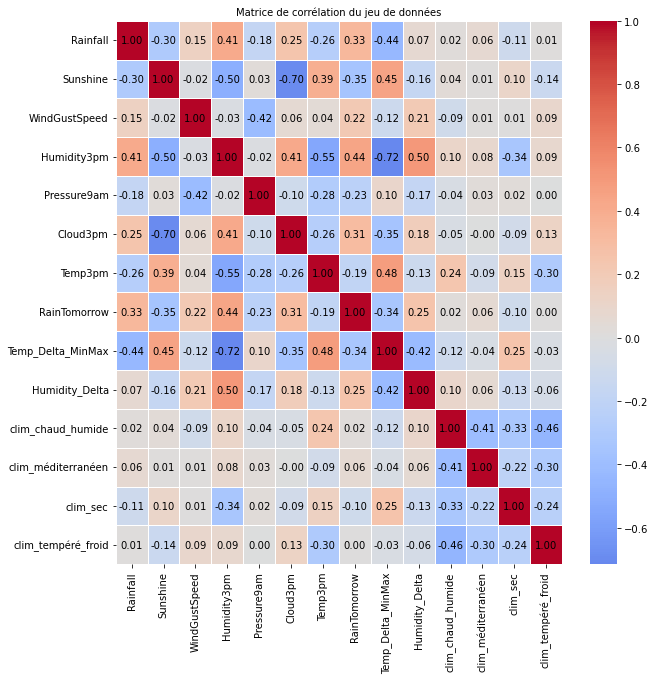

In [28]:
# matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10, 'color':"k", 'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- "Humidity3pm" et "Temp_Delta_MinMax" sont fortement corrélées (-0.72)
- "Sunshine" et "Cloud3pm" sont fortement corrélées (-0.70)
- "Humidity3pm" et "Temp3pm" sont fortement corrélées (-0.55)

In [29]:
# sauvegarde du jeu de données après prétraitement et après l'étape de classification des villes en fonction du climat
df.to_csv('data/weatherAUS_Rev0.csv')

## Sélection de variables avec SelectKBest

In [5]:
# récupération et aperçu du jeu de données après prétraitement et après l'étape de classification des villes en fonction du climat
df = pd.read_csv("data/weatherAUS_Rev0.csv", index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,1,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,1,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,1,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,1,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,1,0,0,0


In [6]:
# analyse statistique rapide du DataFrame "df" 
df.describe()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
count,140787.000000,140787.000000,140787.000000,140787.00000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,0.485723,7.464994,39.774027,51.45039,1017.675010,4.508838,21.704255,0.221618,11.047056,-17.432103,0.388012,0.209558,0.149147,0.253283
std,0.791851,3.179909,12.945712,20.80663,7.020096,2.217148,6.915140,0.415337,4.955324,16.392319,0.487299,0.406994,0.356235,0.434893
min,0.000000,0.000000,6.000000,0.00000,998.650000,0.000000,1.900000,0.000000,-3.750000,-63.500000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.160000,31.000000,37.00000,1012.900000,3.000000,16.600000,0.000000,7.200000,-29.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.630540,39.000000,52.00000,1017.600000,4.499250,21.100000,0.000000,10.500000,-17.000000,0.000000,0.000000,0.000000,0.000000
75%,0.800000,9.700000,48.000000,66.00000,1022.400000,6.000000,26.400000,0.000000,14.500000,-6.000000,1.000000,0.000000,0.000000,1.000000
max,2.000000,14.500000,73.500000,100.00000,1036.650000,9.000000,41.100000,1.000000,25.450000,28.500000,1.000000,1.000000,1.000000,1.000000


In [7]:
# sauvegarde temporaire du DataFrame "df"
df_copy = df.copy()

In [8]:
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']

In [9]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [10]:
# ajustement des données pour l'utilisation de la méthode SelectKBest() qui nécessite des données positives pour le chi2
X_Kbest = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns)

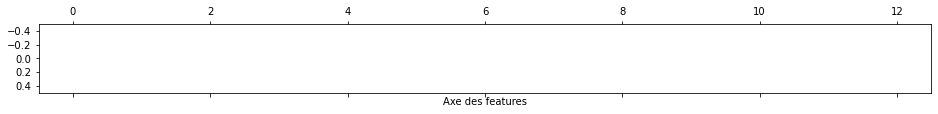

In [11]:
# représentation des variables les plus pertinentes selon la méthode SelectKBest()
sel = SelectKBest(score_func=chi2, k=13)
sel.fit(X_Kbest, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

- toutes les variables semblent pertinentes selon la méthode SelectKBest()

In [12]:
# affichage du nom de toutes les variables à sélectionner selon la méthode SelectKBest()
select_feats = X_train.columns[mask]
select_feats

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am',
       'Cloud3pm', 'Temp3pm', 'Temp_Delta_MinMax', 'Humidity_Delta',
       'clim_chaud_humide', 'clim_méditerranéen', 'clim_sec',
       'clim_tempéré_froid'],
      dtype='object')

In [17]:
# redéfinition du DataFrame "df" en ne gardant que les variables sélectionnées par la méthode SelectKBest()
df = df[select_feats.insert(13,"RainTomorrow")]

In [18]:
# affichage des colonnes du DataFrame "df"
df.columns

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am',
       'Cloud3pm', 'Temp3pm', 'Temp_Delta_MinMax', 'Humidity_Delta',
       'clim_chaud_humide', 'clim_méditerranéen', 'clim_sec',
       'clim_tempéré_froid', 'RainTomorrow'],
      dtype='object')

## Sauvegarde finale du jeu de données

In [19]:
# sauvegarde du jeu de données après prétraitement, après l'étape de classification des villes en fonction du climat 
# et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df.to_csv('data/weatherAUS_preprocessed.csv')